In [1]:
import os ##冰激淋+擔擔麵+蜂蜜檸檬適用

os.environ["CUDA_VISIBLE_DEVICES"] = "0" #使用第0張顯卡 ##冰激淋+擔擔麵+蜂蜜檸檬適用 0or1

In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.45
set_session(tf.Session(config=config))

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import keras
from keras import regularizers
from keras import backend as K
from keras.layers import Input, LSTM, Dense, Dropout, Flatten, Convolution1D, MaxPooling1D, Activation, BatchNormalization,\
Lambda, Concatenate, Add, Conv2D, Conv1D,TimeDistributed
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import PReLU
from keras.models import Model
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
from itertools import permutations
from PIL import Image
import matplotlib.pyplot as plt
import psutil
import os
import numpy as np
import pandas as pd
import datetime
import warnings
import pickle
import csv
import random
from keras.models import Sequential
from keras import backend as K


In [4]:
"""
基本設定
"""
n=148335 #用2016 1~3月的資料 288x(31+29+31+30+31+30+...)=52416 210528-1(all) 差值在減一  
l=72 #288個一組 (24小時一組)
currency = ["BTC","DASH","ETH","JPY","EUR","AUD"]
currencynum = len(currency)
month = [0,31,60,91,121,152,182,213,244,274,305,335,366,397,425,456,486,517,547,578,609,639,670,700,731] #2016是閏年 366天
daynum = [0,5802,11745,18351,24380,30579,36861,42795,49201,55342,61230,67400,73732,79984,85726,92343,98127,104692,111028,117076,123700,129807,136083,142401,148335]
#currency = ["BTC","DASH","ETH","LTC","JBY","GBP","EUR","AUD","US"]
question = ["trand","volatility"]
# 貨幣組合，1 : P, 0 : C
M=0
head = 12
tail = 20
epochs = 60
batch_size = 4096

all_cur_pair = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
if(M==0):
    all_cur_pair_P = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
elif(M==1):
    all_cur_pair_P = list(permutations(currency,2))# (Pn取2) 問題有先後順序時使用  
all_question= list(permutations(question,1))
np.set_printoptions(suppress=True)#不要用科學符號輸出
btc = 423.51
DASH = 0.00778 * btc
ETH = 0.0021652 * btc
LTC = 0.00805792 * btc
XMR = 0.00105001 * btc
JPY = 120.287 * btc
EUR = 1.08643 * btc
AUD = 0.7277 * btc

In [5]:
"""
 V
"""
"""
diff
"""
df = pd.read_csv('btc_data_ver2.0.csv',header=None)  # 讀取訓練數據
print(df.shape)  
btc5months = np.zeros(n)
for i in range(n):
    btc5months[i] = df[0][i]
df = pd.read_csv('DASH_data_ver2.0.csv',header=None)  # 讀取訓練數據
print(df.shape)  
dash5months = np.zeros(n)
for i in range(n):
    dash5months[i] = df[0][i]
df = pd.read_csv('eth_data_ver2.0.csv',header=None)  # 讀取訓練數據
print(df.shape)  
eth5months = np.zeros(n)
for i in range(n):
    eth5months[i] = df[0][i]
df = pd.read_csv('LTC_data_ver2.0.csv',header=None)  # 讀取訓練數據
print(df.shape)  
ltc5months = np.zeros(n)
for i in range(n):
    ltc5months[i] = df[0][i]
df = pd.read_csv('XMR_data_ver2.0.csv',header=None)  # 讀取訓練數據
print(df.shape)  
xmr5months = np.zeros(n)
for i in range(n):
    xmr5months[i] = df[0][i]    
df = pd.read_csv('JPY_data_ver2.0.csv',header=None)  # 讀取訓練數據
print(df.shape)  
jpy5months = np.zeros(n)
for i in range(n):
    jpy5months[i] = df[0][i]  
df = pd.read_csv('EUR_data_ver2.0.csv',header=None)  # 讀取訓練數據
print(df.shape)  
eur5months = np.zeros(n)
for i in range(n):
    eur5months[i] = df[0][i]  
df = pd.read_csv('AUD_data_ver2.0.csv',header=None)  # 讀取訓練數據
print(df.shape)  
aud5months = np.zeros(n)
for i in range(n):
    aud5months[i] = df[0][i]  
print('finish dataread')
Train_data=np.zeros(((n-l+1,len(currency),l)))
for p in range(n-l+1):
    Train_data[p,0,:]=btc5months[p:p+l]
    Train_data[p,1,:]=dash5months[p:p+l]
    Train_data[p,2,:]=eth5months[p:p+l]
    Train_data[p,3,:]=jpy5months[p:p+l]
    Train_data[p,4,:]=eur5months[p:p+l]
    Train_data[p,5,:]=aud5months[p:p+l]
    

(148335, 1)
(148335, 1)
(148335, 1)
(148335, 1)
(148335, 1)
(148335, 1)
(148335, 1)
(148335, 1)
finish dataread


In [6]:
"""""""""
str, onehotcode, company code轉換
"""""""""


currencylist = {}
questionlist = {}
for i in range(len(currency)):
    currencylist[i] = currency[i]

for i in range(len(question)):
    questionlist[i] = question[i]

def str_to_currency(cur):
    return {v: k for k, v in currencylist.items()}[cur]

def str_to_question(q):
    return {v: k for k, v in questionlist.items()}[q]


def one_hot_currency(currencylist):
    d = {}
    temp = np.eye((len(currencylist)))
    for i in range(len(currencylist)):
        d[i] = temp[i]
    return d

def one_hot_question(questionlist):
    d = {}
    temp = np.eye((len(questionlist)))
    for i in range(len(questionlist)):
        d[i] = temp[i]
    return d

onehotcurrency = one_hot_currency(currencylist)
onehotquestion = one_hot_question(questionlist)

In [7]:
"""
Q&A
"""
vol='volatility'
def set_question(com1, com2, condition,typeq):
    # set condition
    def rise_of_fall():
        #目前問題設定只有三種設定：前者大(big)-0、後者大(small)-1、一樣(s)-2
        tmp = np.eye((2))
        d = {0:tmp[0],1:tmp[1]}
        return d
    # 拼接問題
    return np.concatenate((onehotquestion[str_to_question(typeq)],onehotcurrency[str_to_currency(com1)], onehotcurrency[str_to_currency(com2)], rise_of_fall()[condition]))

qtype = ['big','small']
HVqtype = ['big','small']

"""比漲幅程度類問題"""
def set_question_and_answer_pair(data, data2, n, all_cur_pair_P): #比較波動率大小的問題
    q_pair = {}
    a_pair = {}
    outcome=np.zeros((currencynum,1))
    for c in range(currencynum):
        data2[c]=data2[c]-data2[c][0]
    #data_sum=np.sum(data,axis=1)
    data2_sum=np.sum(data2,axis=1)
    outcome[0]=(data2_sum[0])
    outcome[1]=(data2_sum[1])
    outcome[2]=(data2_sum[2])
    outcome[3]=(data2_sum[3])
    outcome[4]=(data2_sum[4])
    outcome[5]=(data2_sum[5])
    # question_type (目前有3種小問題：前者大、後者大或者一樣)
    for i in range(2):
        tmp_q = []
        tmp_a = []
            
        #先塞question pairs
        for j in range(len(all_cur_pair_P)):
            tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1], i, all_question[0][0]))
        q_pair[i] = tmp_q
        
        #再塞answer pairs
        if(i == 0): #同漲
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] >= outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
        elif(i == 1):
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] < outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
                    
        a_pair[i] = tmp_a
        
    return (data, q_pair, a_pair)


"""History Volatility類問題"""
def set_HVquestion_and_HVanswer_pair(data, data2,all_cur_pair_P): #比較波動率大小的問題
    q_HVpair = {}
    a_HVpair = {}
    outcome=np.zeros((currencynum,1))
    for c in range(currencynum):
        data2[c]=data2[c]-data2[c][0]
    data2_std=np.std(data2,axis=1) 
    outcome[0]=data2_std[0]
    outcome[1]=data2_std[1]
    outcome[2]=data2_std[2]
    outcome[3]=data2_std[3]
    outcome[4]=data2_std[4]
    outcome[5]=data2_std[5]     
    # question_type (目前有3種小問題：前者大、後者大或者一樣)
    for i in range(2):
        tmp_q = []
        tmp_a = []
        
        #先塞question pairs
        for j in range(len(all_cur_pair_P)):
            tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1], i,all_question[1][0]))
        q_HVpair[i] = tmp_q
        
        #再塞answer pairs
        if(i == 0): #前者大
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] >= outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
        elif(i == 1):
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] < outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
                    
        a_HVpair[i] = tmp_a
        
    return (data, q_HVpair, a_HVpair)

In [8]:
"""
網路函數
"""
def ConvolutionNetworks(filter_num,kernel_size):
    def conv(model):
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = (MaxPooling1D(pool_size=6))(model)
        model = BatchNormalization()(model)
        return model
    return conv

def get_dense(n, MLP_unit):
    r = []
    for k in range(n):
        r.append(Dense(MLP_unit, activation='relu'))
    return r

def get_MLP(n, denses):
    def g(x):
        d = x
        for k in range(n):
            d = denses[k](d)
        return d
    return g

def dropout_dense(x,MLP_unit):
    y = Dense(MLP_unit)(x)
    y = Dropout(0.5)(y)
    y = Activation('relu')(y)
    return y

def build_tag(conv):
    d = K.int_shape(conv)[1]
    tag = np.zeros((d,1))
    for i in range(d):
        tag[i] = float(int(i%d))/(d-1)*2-1
    tag = K.variable(tag)
    tag = K.expand_dims(tag,axis=0)
    batch_size = K.shape(conv)[0]
    tag = K.tile(tag,[batch_size,1,1])
    print(K.int_shape(tag))
    return Input(tensor=tag)


In [9]:
"""
此處開始寫rolling
"""

def fit_show(traindata,m1,m2,m3):
    
    vqa_pair = []
    for i in range(m1,m3-l-l,1):
        vqa_pair.append(set_question_and_answer_pair(Train_data[i],Train_data[i+l],i+l-1,all_cur_pair_P))  
        vqa_pair.append(set_HVquestion_and_HVanswer_pair(Train_data[i],Train_data[i+l],all_cur_pair_P))
        #這裡交叉塞資料才不會不小心預測未來
            
    # 處理訓練資料
    v_tmp, q_tmp, a_tmp = [],[],[]
    for i in range(len(vqa_pair)):
        v_tmp.append(vqa_pair[i][0])
        q_tmp.append(vqa_pair[i][1])
        a_tmp.append(vqa_pair[i][2])
    v = np.array(v_tmp)
    
    # 下面這行會導致memory error
    import tracemalloc
    # Start tracing
    tracemalloc.start()
    v = np.repeat(v, len(all_cur_pair_P)*len(qtype), axis = 0)
    #這裡要注意問題的分類數量(2種:波動和漲跌)已經在前面vqa_pair變成兩倍過了
    #這裡只要考慮貨幣組合數量(P的N取2)和問的問題數量(高低同)
    snap = tracemalloc.take_snapshot()
    # Evaluate result
    stats = snap.statistics('lineno')
    for stat in stats[:1]:
        print(stat)
    
    q, a = [],[]
    for i in range(len(q_tmp)):
        for value in q_tmp[i].values():
            q.append(value)
    q = np.vstack(q)
    q = np.vstack(q)
    
    for i in range(len(a_tmp)):
        for value in a_tmp[i].values():
            a.append(value)
    a = np.vstack(a)
    a = a.reshape(a.shape[0]*a.shape[1])
    v=np.swapaxes(v,1,2)
    print("[Training model......]")

    Train_v=v[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]# -1-72+1=-72
    Train_q=q[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Train_a=a[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Test_v=v[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_q=q[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_a=a[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    history = model.fit([Train_v, Train_q], Train_a, validation_data=([Test_v,Test_q],Test_a),batch_size=batch_size ,epochs = epochs,shuffle=False)
    pred = model.predict([Test_v, Test_q])
    count = 0
    print(pred)
    for i in range(pred.shape[0]):
        if pred[i] <= 0.5:
            pred[i] = 0
        else:
            pred[i] = 1
            
        if pred[i] == Test_a[i]:
            count+=1
    print(count,count/pred.shape[0])
    """
    分開兩種問題的test集
    """
    flag=0
    v_trend=[]
    q_trend=[]
    a_trend=[]
    v_vol=[]
    q_vol=[]
    a_vol=[]
    trend_count=0
    vol_count=0
    for ii in range(0,len(Test_q)):
        if(flag==0):
            #print(0)
            v_trend.append(Test_v[ii])
            q_trend.append(Test_q[ii])
            a_trend.append(Test_a[ii])
            trend_count=trend_count+1
            if(trend_count==60):
                trend_count=0
                flag=1
        elif(flag==1):
            #print(1)
            v_vol.append(Test_v[ii])
            q_vol.append(Test_q[ii])
            a_vol.append(Test_a[ii])
            vol_count=vol_count+1
            if(vol_count==60):
                vol_count=0
                flag=0
    
    """
    分開兩種問題的predict正確率
    """
    pred_trend = model.predict([v_trend, q_trend])
    count = 0
    for i in range(pred_trend.shape[0]):
        if pred_trend[i] <= 0.5:
            pred_trend[i] = 0
        else:
            pred_trend[i] = 1
            
        if pred_trend[i] == a_trend[i]:
            count+=1
    print("trend_test_acc:")
    print(count,count/pred_trend.shape[0])    
    total_test_trend.append(count/pred_trend.shape[0])

    pred_vol = model.predict([v_vol, q_vol])
    count = 0
    for i in range(pred_vol.shape[0]):
        if pred_vol[i] <= 0.5:
            pred_vol[i] = 0
        else:
            pred_vol[i] = 1
            
        if pred_vol[i] == a_vol[i]:
            count+=1
    print("vol_test_acc:")
    print(count,count/pred_vol.shape[0]) 
    total_test_vol.append(count/pred_vol.shape[0])


    """
    算benchmark
    """
    benchacc=0
    for i in range(Test_a.shape[0]):
        benchacc=benchacc+Test_a[i]
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("benchacc:")
    print(benchacc)
    """
    畫圖
    """
    benchfunction=np.ones(a.shape[0])
    benchfunction=benchfunction*benchacc
    plt.plot(history.history['loss'], label='train')
    lastepoch_train_loss.append(history.history['loss'][-1])
    plt.plot(history.history['val_loss'], label='test')
    lastepoch_test_loss.append(history.history['val_loss'][-1])
    print("loss:")
    print(history.history['loss'][-1])
    print("val_loss:")
    print(history.history['val_loss'][-1])
    plt.xlabel("epoch") 
    plt.ylabel("loss") 
    #plt.title("The Title") 
    plt.legend()
    plt.show()
    
    
    plt.plot(history.history['acc'], label='train')
    lastepoch_train_acc.append(history.history['acc'][-1])
    plt.plot(history.history['val_acc'], label='test')
    lastepoch_test_acc.append(history.history['val_acc'][-1])  
    plt.plot(np.arange(epochs),np.repeat(benchacc,epochs), label='benchmark')
    print("acc:")
    print(history.history['acc'][-1])
    print("val_acc:")
    print(history.history['val_acc'][-1])
    plt.xlabel("epoch") 
    plt.ylabel("acc") 
    #plt.title("The Title") 
    plt.legend()
    plt.show()

(None, 10, 1)
g_MLP
drop_out
compile model success
12
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=4796 MiB, count=2, average=2398 MiB
[Training model......]
Train on 1108020 samples, validate on 338400 samples
Epoch 1/60
1108020/1108020 [==============================] - 94s 85us/step - loss: 1.2510 - acc: 0.5314 - val_loss: 0.6258 - val_acc: 0.6595
Epoch 2/60
1108020/1108020 [==============================] - 48s 43us/step - loss: 0.6658 - acc: 0.6022 - val_loss: 0.5809 - val_acc: 0.6688
Epoch 3/60
1108020/1108020 [==============================] - 48s 43us/step - loss: 0.5890 - acc: 0.6484 - val_loss: 0.5263 - val_acc: 0.6715
Epoch 4/60
1108020/1108020 [==============================] - 48s 43us/step - loss: 0.5340 - acc: 0.6776 - val_loss: 0.4876 - val_acc: 0.7046
Epoch 5/60
1108020/1108020 [==============================] - 48s 43us/step - loss: 0.5014 - acc: 0.6914 - val_loss: 0.4687 - val_acc: 0.7103
Epoch 6/60
1108020/1108020 [==================

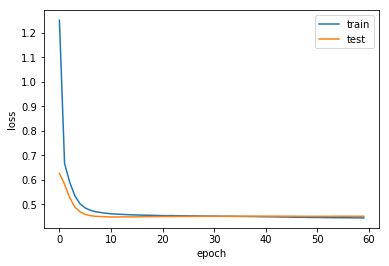

acc:
0.7157659608774117
val_acc:
0.7091341607959558


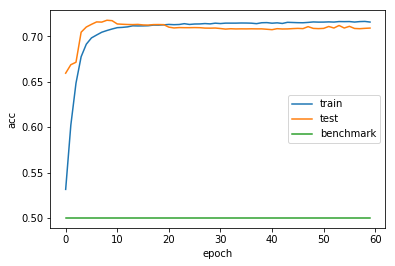

(None, 10, 1)
g_MLP
drop_out
compile model success
13
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=4858 MiB, count=257, average=18.9 MiB
[Training model......]
Train on 1079940 samples, validate on 385260 samples
Epoch 1/60
1079940/1079940 [==============================] - 93s 86us/step - loss: 1.5860 - acc: 0.5188 - val_loss: 0.6618 - val_acc: 0.6094
Epoch 2/60
1079940/1079940 [==============================] - 46s 43us/step - loss: 0.7335 - acc: 0.5649 - val_loss: 0.6095 - val_acc: 0.6689
Epoch 3/60
1079940/1079940 [==============================] - 45s 41us/step - loss: 0.6187 - acc: 0.6233 - val_loss: 0.5512 - val_acc: 0.6847
Epoch 4/60
1079940/1079940 [==============================] - 45s 42us/step - loss: 0.5653 - acc: 0.6573 - val_loss: 0.5115 - val_acc: 0.6882
Epoch 5/60
1079940/1079940 [==============================] - 45s 42us/step - loss: 0.5260 - acc: 0.6770 - val_loss: 0.4876 - val_acc: 0.6927
Epoch 6/60
1079940/1079940 [================

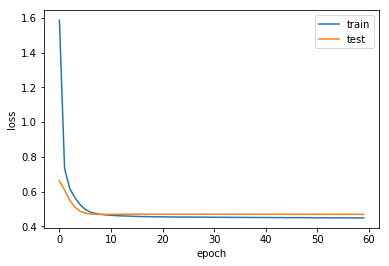

acc:
0.7120182602637842
val_acc:
0.6935601931299518


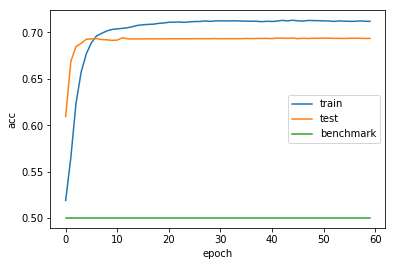

(None, 10, 1)
g_MLP
drop_out
compile model success
14
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=4975 MiB, count=259, average=19.2 MiB
[Training model......]
Train on 1129320 samples, validate on 371520 samples
Epoch 1/60
1129320/1129320 [==============================] - 100s 89us/step - loss: 1.3530 - acc: 0.5115 - val_loss: 0.6601 - val_acc: 0.5974
Epoch 2/60
1129320/1129320 [==============================] - 47s 42us/step - loss: 0.7165 - acc: 0.5659 - val_loss: 0.6080 - val_acc: 0.6473
Epoch 3/60
1129320/1129320 [==============================] - 48s 42us/step - loss: 0.6184 - acc: 0.6227 - val_loss: 0.5474 - val_acc: 0.6589
Epoch 4/60
1129320/1129320 [==============================] - 48s 43us/step - loss: 0.5550 - acc: 0.6571 - val_loss: 0.5040 - val_acc: 0.6729
Epoch 5/60
1129320/1129320 [==============================] - 48s 43us/step - loss: 0.5098 - acc: 0.6776 - val_loss: 0.4854 - val_acc: 0.6871
Epoch 6/60
1129320/1129320 [===============

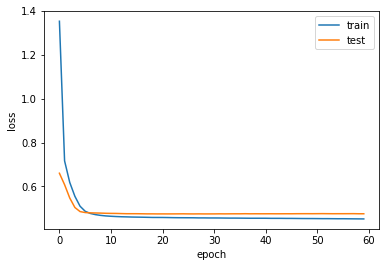

acc:
0.7088885347331338
val_acc:
0.6945817181614327


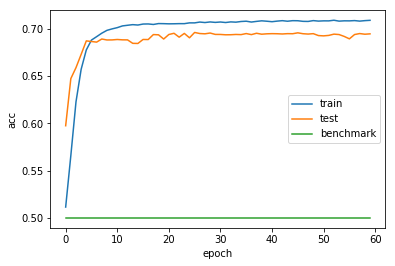

(None, 10, 1)
g_MLP
drop_out
compile model success
15
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=4863 MiB, count=261, average=18.6 MiB
[Training model......]
Train on 1112460 samples, validate on 354240 samples
Epoch 1/60
1112460/1112460 [==============================] - 101s 91us/step - loss: 1.1746 - acc: 0.5297 - val_loss: 0.6319 - val_acc: 0.6404
Epoch 2/60
1112460/1112460 [==============================] - 46s 41us/step - loss: 0.6863 - acc: 0.5833 - val_loss: 0.5760 - val_acc: 0.6454
Epoch 3/60
1112460/1112460 [==============================] - 46s 41us/step - loss: 0.6043 - acc: 0.6254 - val_loss: 0.5269 - val_acc: 0.6462
Epoch 4/60
1112460/1112460 [==============================] - 46s 41us/step - loss: 0.5486 - acc: 0.6543 - val_loss: 0.4938 - val_acc: 0.6749
Epoch 5/60
1112460/1112460 [==============================] - 46s 41us/step - loss: 0.5134 - acc: 0.6731 - val_loss: 0.4793 - val_acc: 0.6767
Epoch 6/60
1112460/1112460 [===============

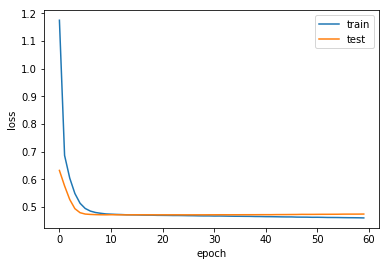

acc:
0.7036765367144694
val_acc:
0.6877060750204912


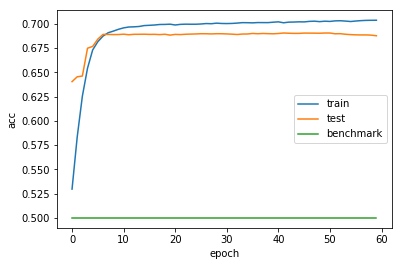

(None, 10, 1)
g_MLP
drop_out
compile model success
16
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=5029 MiB, count=262, average=19.2 MiB
[Training model......]
Train on 1128300 samples, validate on 388800 samples
Epoch 1/60
1128300/1128300 [==============================] - 98s 87us/step - loss: 1.3072 - acc: 0.5136 - val_loss: 0.6812 - val_acc: 0.5459
Epoch 2/60
1128300/1128300 [==============================] - 49s 43us/step - loss: 0.7241 - acc: 0.5481 - val_loss: 0.6432 - val_acc: 0.6274
Epoch 3/60
1128300/1128300 [==============================] - 48s 43us/step - loss: 0.6561 - acc: 0.5940 - val_loss: 0.5983 - val_acc: 0.6442
Epoch 4/60
1128300/1128300 [==============================] - 49s 43us/step - loss: 0.5935 - acc: 0.6352 - val_loss: 0.5439 - val_acc: 0.6529
Epoch 5/60
1128300/1128300 [==============================] - 49s 43us/step - loss: 0.5398 - acc: 0.6566 - val_loss: 0.5116 - val_acc: 0.6650
Epoch 6/60
1128300/1128300 [================

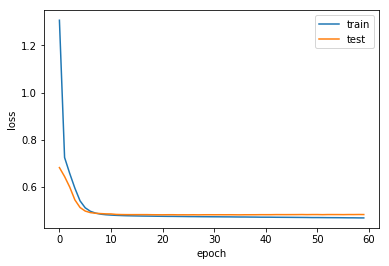

acc:
0.6966666666377175
val_acc:
0.6667849792178275


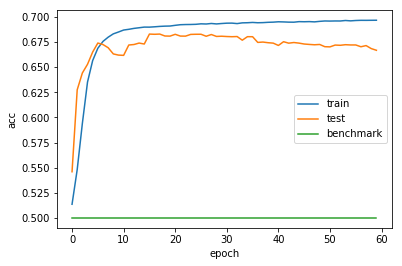

(None, 10, 1)
g_MLP
drop_out
compile model success
17
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=4938 MiB, count=263, average=18.8 MiB
[Training model......]
Train on 1131840 samples, validate on 357780 samples
Epoch 1/60
1131840/1131840 [==============================] - 101s 89us/step - loss: 0.9784 - acc: 0.5216 - val_loss: 0.6426 - val_acc: 0.6353
Epoch 2/60
1131840/1131840 [==============================] - 47s 42us/step - loss: 0.6675 - acc: 0.5917 - val_loss: 0.5685 - val_acc: 0.6844
Epoch 3/60
1131840/1131840 [==============================] - 47s 42us/step - loss: 0.5907 - acc: 0.6392 - val_loss: 0.5057 - val_acc: 0.6858
Epoch 4/60
1131840/1131840 [==============================] - 47s 42us/step - loss: 0.5357 - acc: 0.6567 - val_loss: 0.4758 - val_acc: 0.6828
Epoch 5/60
1131840/1131840 [==============================] - 47s 42us/step - loss: 0.5092 - acc: 0.6633 - val_loss: 0.4694 - val_acc: 0.6810
Epoch 6/60
1131840/1131840 [===============

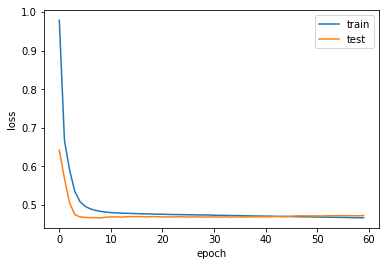

acc:
0.6884524314222209
val_acc:
0.6770333723569038


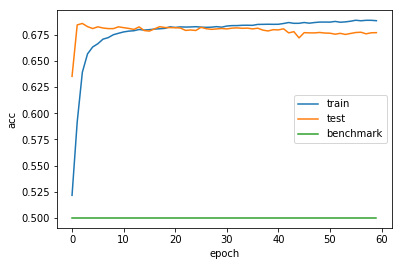

(None, 10, 1)
g_MLP
drop_out
compile model success
18
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=9864 MiB, count=265, average=37.2 MiB
[Training model......]
Train on 1118100 samples, validate on 367920 samples
Epoch 1/60
1118100/1118100 [==============================] - 102s 91us/step - loss: 1.1018 - acc: 0.5279 - val_loss: 0.6322 - val_acc: 0.6632
Epoch 2/60
1118100/1118100 [==============================] - 48s 43us/step - loss: 0.6697 - acc: 0.5971 - val_loss: 0.5617 - val_acc: 0.6658
Epoch 3/60
1118100/1118100 [==============================] - 48s 43us/step - loss: 0.5923 - acc: 0.6354 - val_loss: 0.4982 - val_acc: 0.6875
Epoch 4/60
1118100/1118100 [==============================] - 48s 43us/step - loss: 0.5442 - acc: 0.6557 - val_loss: 0.4690 - val_acc: 0.7009
Epoch 5/60
1118100/1118100 [==============================] - 48s 43us/step - loss: 0.5171 - acc: 0.6671 - val_loss: 0.4607 - val_acc: 0.7100
Epoch 6/60
1118100/1118100 [===============

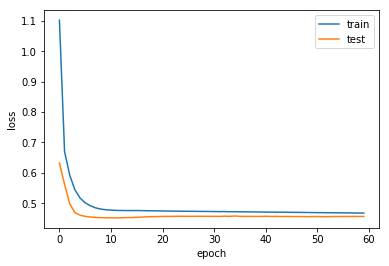

acc:
0.6895590734846444
val_acc:
0.7126386169507001


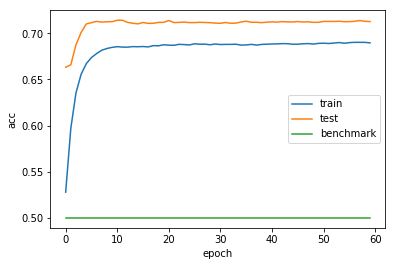

(None, 10, 1)
g_MLP
drop_out
compile model success
19
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=4980 MiB, count=263, average=18.9 MiB
[Training model......]
Train on 1131780 samples, validate on 370440 samples
Epoch 1/60
1131780/1131780 [==============================] - 105s 93us/step - loss: 1.2483 - acc: 0.5268 - val_loss: 0.6406 - val_acc: 0.6516
Epoch 2/60
1131780/1131780 [==============================] - 47s 42us/step - loss: 0.6678 - acc: 0.6055 - val_loss: 0.5837 - val_acc: 0.6626
Epoch 3/60
1131780/1131780 [==============================] - 47s 42us/step - loss: 0.5815 - acc: 0.6520 - val_loss: 0.5263 - val_acc: 0.6674
Epoch 4/60
1131780/1131780 [==============================] - 48s 42us/step - loss: 0.5294 - acc: 0.6691 - val_loss: 0.4945 - val_acc: 0.6827
Epoch 5/60
1131780/1131780 [==============================] - 48s 42us/step - loss: 0.5027 - acc: 0.6774 - val_loss: 0.4824 - val_acc: 0.6905
Epoch 6/60
1131780/1131780 [===============

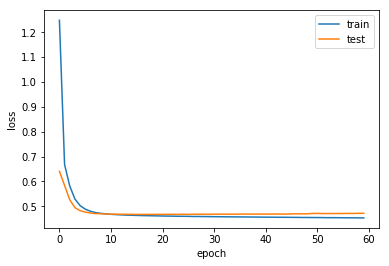

acc:
0.7026780823345148
val_acc:
0.6926708779612032


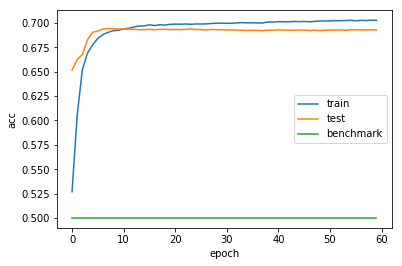

In [10]:
lastepoch_train_acc = []
lastepoch_test_acc = []
lastepoch_train_loss = []
lastepoch_test_loss = []
total_test_vol = []
total_test_trend = []

train_length=3
test_length=1
for i in range(head,tail,1):

    MLP_unit=64
    visual_scene = Input((l,currencynum))
    visual_conv = ConvolutionNetworks(20,5)(visual_scene)
    tag = build_tag(visual_conv)
    visual_conv = Concatenate()([visual_conv, tag])
    shapes = visual_conv.shape
    w = shapes[1]
    features= []
    for k1 in range(w):
        def get_feature(t):
            return t[:, k1, :]
        get_feature_layer = Lambda(get_feature)
        features.append(get_feature_layer(visual_conv))

    input2 = Input((16,))
    onehot_encode = input2   

    relations = []
    concat = Concatenate()
    for feature1 in features:
        for feature2 in features:
            relations.append(concat([feature1, feature2, onehot_encode]))    


    g_MLP = get_MLP(5, get_dense(5,MLP_unit))
    f_MLP = get_MLP(5, get_dense(5,MLP_unit))
    print("g_MLP")
    mid_relations = []
    for r in relations:
        mid_relations.append(g_MLP(r))

    combined_relation = Add()(mid_relations)

    #f_MLP
    rn = dropout_dense(combined_relation,MLP_unit)
    rn = dropout_dense(rn,MLP_unit)
    print('drop_out')

    pred = Dense(1, activation = 'sigmoid')(rn)

    model = Model(inputs=[visual_scene, input2, tag], outputs = pred)
    optimizer = Adam(lr = 3e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    print('compile model success')    

    #model.summary()
    print(i)
    fit_show(Train_data,daynum[i],daynum[i+3],daynum[i+4])

train_acc:red,test_acc:blue


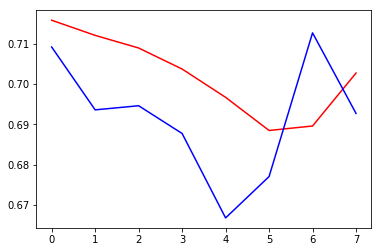

train_loss:red,test_loss:blue


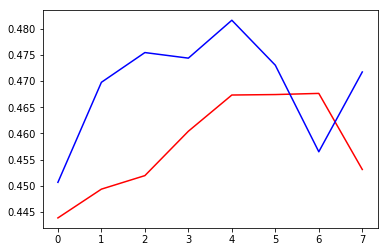

trend:red,vol:blue


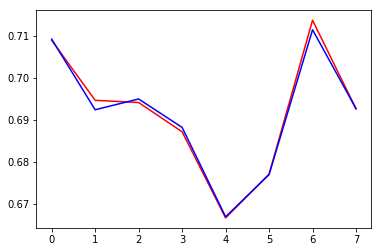

In [11]:
print("train_acc:red,test_acc:blue")    
plt.plot(lastepoch_train_acc,color='r')
plt.plot(lastepoch_test_acc,color='b')
plt.show()
print("train_loss:red,test_loss:blue")
plt.plot(lastepoch_train_loss,color='r')
plt.plot(lastepoch_test_loss,color='b')
plt.show()
print("trend:red,vol:blue")
plt.plot(total_test_trend,color='r')
plt.plot(total_test_vol,color='b')
plt.show()